# Some Interesting CNN formulations

Attempted several different methods of structuring input to the CNN - including Fourier Transforming the signal, etc. 

In [1]:
# Imports and setup

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM
from keras.layers import GRU
import matplotlib.pyplot as plt

from utils.load_data import *
from utils.utilities import *
from models.cnn import CNN
from models.rnn import RNN
from models.fft_cnn import FFT_CNN_1, FFT_CNN_2, FFT_FCNET
from models.autoencoder import Autoencoder
#from models.VAE import *


%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Load Data

In [2]:
# Loads data from the EEG dataset and removes all EOG data

person_train_val, X_train_val, y_train_val, person_test, X_test, y_test = load_EEG_data()

print ('Training/Valid data shape: {}'.format(X_train_val.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_val.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_val.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


## Split into train and validation datasets

In [3]:
X_train, y_train, X_val, y_val = split_train_val(X_train_val, y_train_val, percent_validation=0.1)

print ('Training data shape: {}'.format(X_train.shape))
print ('Training target shape: {}'.format(y_train.shape))
print ('Validation data shape: {}'.format(X_val.shape))
print ('Validation target shape: {}'.format(y_val.shape))

Training data shape: (1904, 22, 1000)
Training target shape: (1904,)
Validation data shape: (211, 22, 1000)
Validation target shape: (211,)


## One hot encoding for all labels

In [4]:
print (y_val[33])
print (y_val.shape)
print (y_test.shape)

y_train_labels = one_hot_encode(y_train)
y_val_labels = one_hot_encode(y_val)
y_test_labels = one_hot_encode(y_test)

print (y_val_labels[33])
print (y_val_labels.shape)
print (y_test_labels.shape)

770
(211,)
(443,)
[0. 1. 0. 0.]
(211, 4)
(443, 4)


## Visualizing Data under FFT 

/Users/HirdayGupta/Documents/UCLA/Winter_19/ECE_239AS/Homeworks/neural_nets/env/lib/python3.6/site-packages/matplotlib/transforms.py:827: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


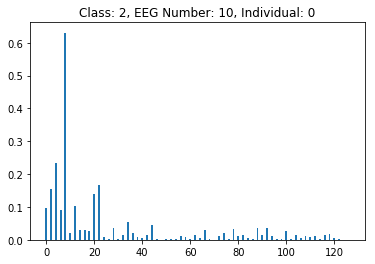

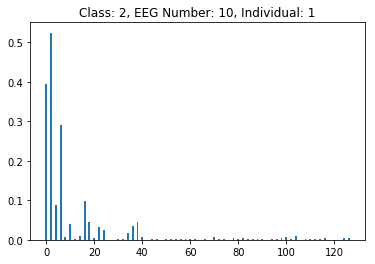

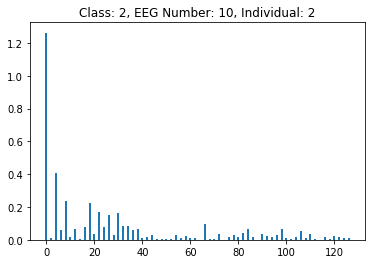

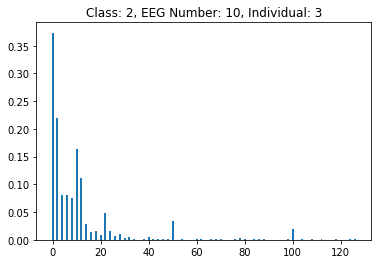

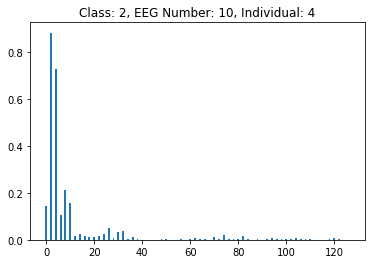

In [5]:
class1_idx = np.argwhere(y_train==769).flatten()
class2_idx = np.argwhere(y_train==770).flatten()
class3_idx = np.argwhere(y_train==771).flatten()
class4_idx = np.argwhere(y_train==772).flatten()

class_idxs = [class1_idx, class2_idx, class3_idx, class4_idx]

EEG_NUM = 10 # 0-21
CLASS_NUM = 2 # 0,1,2,3

for i in np.arange(5):
    EEG_trial = X_train[class_idxs[CLASS_NUM][i],EEG_NUM,:]
    EEG_trial_fft, freqs = fft_electrode_data(EEG_trial)
    plt.bar(freqs, EEG_trial_fft)
    plt.title("Class: {}, EEG Number: {}, Individual: {}".format(CLASS_NUM, EEG_NUM, i))
    plt.show()

## Handcrafting features for CNN using FFT and Evaluating Performance

In [6]:
X_train_fft, X_val_fft, X_test_fft = fft_and_reshape(X_train), fft_and_reshape(X_val), fft_and_reshape(X_test)

print (X_train_fft.shape)
print (X_val_fft.shape)
print (X_test_fft.shape)

# Note: Went from 1000 timesteps to 64 power densities for 64 frequencies (between 0 & 128)

/Users/HirdayGupta/Documents/UCLA/Winter_19/ECE_239AS/Homeworks/neural_nets/utils/utilities.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  X_fft[i][j] = EEG_trial_FFT


(1904, 64, 22)
(211, 64, 22)
(443, 64, 22)


In [7]:
cnn = FFT_CNN_1(X_train_fft, y_train_labels, X_val_fft, y_val_labels, X_test_fft, y_test_labels, dropout=0.25)
cnn.train(stride=1, optimizer='adam', epochs=20)
test_loss, test_accuracy = cnn.evaluate()

#cnn.show_model()
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 1904 samples, validate on 211 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
1904/1904 [==============================] - 5s 2ms/sample - loss: 1.3931 - acc: 0.2563 - val_loss: 1.4012 - val_acc: 0.2938
Epoch 2/20
1904/1904 [==============================] - 4s 2ms/sample - loss: 1.3888 - acc: 0.2505 - val_loss: 1.3935 - val_acc: 0.2227
Epoch 3/20
1904/1904 [==============================] - 5s 2ms/sample - loss: 1.3858 - acc: 0.2689 - val_loss: 1.3938 - val_acc: 0.2322
Epoch 4/20
1904/1904 [==============================] - 5s 2ms/sample - loss: 1.3848 - acc: 0.2616 - val_loss: 1.3933 - val_acc: 0.1991
Epoch 5/20
1904/1904 [==============================] - 4s 2ms/sample - loss: 1.3837 - acc: 0.2637 - val_loss: 1.3892 - val_acc: 0.1943
Epoch 6/20
1904/1904 [================

In [8]:
cnn = FFT_CNN_1(X_train_fft, y_train_labels, X_val_fft, y_val_labels, X_test_fft, y_test_labels, dropout=0.3, use_elu=True)
cnn.train(stride=1, optimizer='adam', epochs=20)
test_loss, test_accuracy = cnn.evaluate()

#cnn.show_model()
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Train on 1904 samples, validate on 211 samples
Epoch 1/20
1904/1904 [==============================] - 5s 3ms/sample - loss: 1.4335 - acc: 0.2516 - val_loss: 1.3814 - val_acc: 0.2512
Epoch 2/20
1904/1904 [==============================] - 5s 3ms/sample - loss: 1.4042 - acc: 0.2810 - val_loss: 1.4630 - val_acc: 0.2938
Epoch 3/20
1904/1904 [==============================] - 5s 3ms/sample - loss: 1.4033 - acc: 0.2658 - val_loss: 1.3569 - val_acc: 0.3365
Epoch 4/20
1904/1904 [==============================] - 5s 2ms/sample - loss: 1.3899 - acc: 0.2841 - val_loss: 1.5118 - val_acc: 0.2512
Epoch 5/20
1904/1904 [==============================] - 5s 2ms/sample - loss: 1.3865 - acc: 0.2978 - val_loss: 1.4942 - val_acc: 0.2322
Epoch 6/20
1904/1904 [==============================] - 4s 2ms/sample - loss: 1.3862 - acc: 0.3004 - val_loss: 1.5196 - val_acc: 0.2370
Epoch 7/20
1904/1904 [==============================] - 5s 3ms/sample - loss: 1.3948 - acc: 0.3078 - val_loss: 1.5030 - val_acc: 0.2275
E

In [9]:
cnn = FFT_CNN_1(X_train_fft, y_train_labels, X_val_fft, y_val_labels, X_test_fft, y_test_labels, dropout=0.7, use_elu=True, use_batchnorm=True)
cnn.train(stride=1, optimizer='adam', epochs=10)
test_loss, test_accuracy = cnn.evaluate()

#cnn.show_model()
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Train on 1904 samples, validate on 211 samples
Epoch 1/10
1904/1904 [==============================] - 6s 3ms/sample - loss: 1.6217 - acc: 0.2521 - val_loss: 1.3785 - val_acc: 0.2938
Epoch 2/10
1904/1904 [==============================] - 5s 2ms/sample - loss: 1.4966 - acc: 0.2411 - val_loss: 1.3987 - val_acc: 0.2844
Epoch 3/10
1904/1904 [==============================] - 5s 3ms/sample - loss: 1.4549 - acc: 0.2663 - val_loss: 1.3912 - val_acc: 0.2938
Epoch 4/10
1904/1904 [==============================] - 5s 3ms/sample - loss: 1.4497 - acc: 0.2468 - val_loss: 1.4139 - val_acc: 0.2038
Epoch 5/10
1904/1904 [==============================] - 5s 3ms/sample - loss: 1.4367 - acc: 0.2595 - val_loss: 1.3855 - val_acc: 0.3033
Epoch 6/10
1904/1904 [==============================] - 5s 2ms/sample - loss: 1.4495 - acc: 0.2495 - val_loss: 1.3903 - val_acc: 0.2133
Epoch 7/10
1904/1904 [==============================] - 5s 3ms/sample - loss: 1.4340 - acc: 0.2542 - val_loss: 1.4096 - val_acc: 0.2559
E

### Reshape FFT data 
Shaped data into a 5x5x64 grid formulation - in an attemp to preserve the spatial locality of the electrodes, using the 64 PSD values associated with 64 frequencies (the output of the FFT) as channels

In [10]:
X_train_fft_sp = reshape_fft_spatial(X_train_fft)
X_val_fft_sp = reshape_fft_spatial(X_val_fft)
X_test_fft_sp = reshape_fft_spatial(X_test_fft)

print (X_train_fft_sp.shape)
print (X_val_fft_sp.shape)
print (X_test_fft_sp.shape)

(1904, 5, 5, 64)
(211, 5, 5, 64)
(443, 5, 5, 64)


In [11]:
cnn = FFT_CNN_2(X_train_fft_sp, y_train_labels, X_val_fft_sp, y_val_labels, X_test_fft_sp, y_test_labels, dropout=0.35, use_batchnorm=True)
cnn.train(stride=1, optimizer='adam', epochs=30)
test_loss, test_accuracy = cnn.evaluate()

#cnn.show_model()
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Train on 1904 samples, validate on 211 samples
Epoch 1/30
1904/1904 [==============================] - 5s 3ms/sample - loss: 1.6710 - acc: 0.2605 - val_loss: 1.3948 - val_acc: 0.2417
Epoch 2/30
1904/1904 [==============================] - 4s 2ms/sample - loss: 1.5913 - acc: 0.2479 - val_loss: 1.3946 - val_acc: 0.2559
Epoch 3/30
1904/1904 [==============================] - 4s 2ms/sample - loss: 1.5189 - acc: 0.2547 - val_loss: 1.4031 - val_acc: 0.2038
Epoch 4/30
1904/1904 [==============================] - 4s 2ms/sample - loss: 1.4628 - acc: 0.2563 - val_loss: 1.3932 - val_acc: 0.2085
Epoch 5/30
1904/1904 [==============================] - 4s 2ms/sample - loss: 1.4634 - acc: 0.2794 - val_loss: 1.4074 - val_acc: 0.2133
Epoch 6/30
1904/1904 [==============================] - 4s 2ms/sample - loss: 1.4361 - acc: 0.2736 - val_loss: 1.3981 - val_acc: 0.2370
Epoch 7/30
1904/1904 [==============================] - 4s 2ms/sample - loss: 1.4359 - acc: 0.2763 - val_loss: 1.4090 - val_acc: 0.2464
E

### Reshape for FCNet

In [12]:
X_train_fft_1d = reshape_fft_1D(X_train_fft)
X_val_fft_1d = reshape_fft_1D(X_val_fft)
X_test_fft_1d = reshape_fft_1D(X_test_fft)

print (X_train_fft_1d.shape)
print (X_val_fft_1d.shape)
print (X_test_fft_1d.shape)

(1904, 1408)
(211, 1408)
(443, 1408)


In [13]:
fcnet = FFT_FCNET(X_train_fft_1d, y_train_labels, X_val_fft_1d, y_val_labels, X_test_fft_1d, y_test_labels, use_batchnorm=True, dropout=0.3)
fcnet.train(optimizer='adam', epochs=30)
test_loss, test_accuracy = fcnet.evaluate()

#cnn.show_model()
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Train on 1904 samples, validate on 211 samples
Epoch 1/30
1904/1904 [==============================] - 2s 858us/sample - loss: 1.6619 - acc: 0.2773 - val_loss: 1.3657 - val_acc: 0.3270
Epoch 2/30
1904/1904 [==============================] - 1s 332us/sample - loss: 1.5278 - acc: 0.2946 - val_loss: 1.4036 - val_acc: 0.2844
Epoch 3/30
1904/1904 [==============================] - 1s 343us/sample - loss: 1.4970 - acc: 0.3025 - val_loss: 1.3790 - val_acc: 0.3081
Epoch 4/30
1904/1904 [==============================] - 1s 318us/sample - loss: 1.4465 - acc: 0.3172 - val_loss: 1.3944 - val_acc: 0.3223
Epoch 5/30
1904/1904 [==============================] - 1s 346us/sample - loss: 1.3890 - acc: 0.3393 - val_loss: 1.3968 - val_acc: 0.3318
Epoch 6/30
1904/1904 [==============================] - 1s 327us/sample - loss: 1.3820 - acc: 0.3545 - val_loss: 1.4265 - val_acc: 0.2844
Epoch 7/30
1904/1904 [==============================] - 1s 336us/sample - loss: 1.3412 - acc: 0.3729 - val_loss: 1.4215 - val